In [1]:
#import dependencies 
import os
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import (
    InceptionResNetV2, preprocess_input, decode_predictions)
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#load the InceptionResNetV2 model without the top layer or output layer
trained_model = InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(299,299,3))

In [3]:
#print out all layers
for layer in trained_model.layers:
    print(layer)

In [4]:
#freeze all layers except last 3 layers and make them trainable
for layer in trained_model.layers[:-8]:
    layer.trainable = False

In [5]:
#check if only the last 3 layers are trainable
for layer in trained_model.layers:
    print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000026E05F07550> False
<keras.layers.convolutional.Conv2D object at 0x0000026E05F07898> False
<keras.layers.normalization.BatchNormalization object at 0x0000026E05F070F0> False
<keras.layers.core.Activation object at 0x0000026E05F07F98> False
<keras.layers.convolutional.Conv2D object at 0x0000026E7B70BA20> False
<keras.layers.normalization.BatchNormalization object at 0x0000026E05FBDDA0> False
<keras.layers.core.Activation object at 0x0000026E0604D630> False
<keras.layers.convolutional.Conv2D object at 0x0000026E05FD3128> False
<keras.layers.normalization.BatchNormalization object at 0x0000026E06097278> False
<keras.layers.core.Activation object at 0x0000026E060AD358> False
<keras.layers.pooling.MaxPooling2D object at 0x0000026E06112BA8> False
<keras.layers.convolutional.Conv2D object at 0x0000026E060EAEB8> False
<keras.layers.normalization.BatchNormalization object at 0x0000026E0616B6A0> False
<keras.layers.core.Activation object at 0x

<keras.layers.core.Activation object at 0x0000026E0BD4AE10> False
<keras.layers.convolutional.Conv2D object at 0x0000026E0BDD56A0> False
<keras.layers.normalization.BatchNormalization object at 0x0000026E0BDB0320> False
<keras.layers.core.Activation object at 0x0000026E0BE48F98> False
<keras.layers.convolutional.Conv2D object at 0x0000026E0BE796D8> False
<keras.layers.normalization.BatchNormalization object at 0x0000026E0BE8BA90> False
<keras.layers.core.Activation object at 0x0000026E0BF3FEF0> False
<keras.layers.convolutional.Conv2D object at 0x0000026E0BD4ACC0> False
<keras.layers.convolutional.Conv2D object at 0x0000026E0BF5C3C8> False
<keras.layers.normalization.BatchNormalization object at 0x0000026E0BD91CC0> False
<keras.layers.normalization.BatchNormalization object at 0x0000026E0BF4EA20> False
<keras.layers.core.Activation object at 0x0000026E0BD9CF28> False
<keras.layers.core.Activation object at 0x0000026E0C017E80> False
<keras.layers.pooling.MaxPooling2D object at 0x0000026

<keras.layers.merge.Concatenate object at 0x0000026E15A02A58> False
<keras.layers.convolutional.Conv2D object at 0x0000026E159E3F60> False
<keras.layers.core.Lambda object at 0x0000026E15A3E8D0> False
<keras.layers.core.Activation object at 0x0000026E15AAAC50> False
<keras.layers.convolutional.Conv2D object at 0x0000026E15B0F550> False
<keras.layers.normalization.BatchNormalization object at 0x0000026E15B0CCC0> False
<keras.layers.core.Activation object at 0x0000026E15B88F60> False
<keras.layers.convolutional.Conv2D object at 0x0000026E15BB8588> False
<keras.layers.normalization.BatchNormalization object at 0x0000026E15BD0940> False
<keras.layers.core.Activation object at 0x0000026E15C81DA0> False
<keras.layers.convolutional.Conv2D object at 0x0000026E15AAA6D8> False
<keras.layers.convolutional.Conv2D object at 0x0000026E15C9B278> False
<keras.layers.normalization.BatchNormalization object at 0x0000026E15AC9EF0> False
<keras.layers.normalization.BatchNormalization object at 0x0000026E1

In [6]:
#create my fine tuned model
my_model = models.Sequential()
#use InceptionResNetV2 model as the base
my_model.add(trained_model)
my_model.add(layers.Flatten())
#add another layer with 'relu' activation
my_model.add(layers.Dense(1536, activation='relu'))
#add drop out regularization to reduce overfit
my_model.add(layers.Dropout(0.5))
#add output layer with 'softmax' activation for 5 classes / flower names
my_model.add(layers.Dense(5, activation='softmax'))

In [7]:
#show model summary
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1536)              150996480 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 7685      
Total params: 205,340,901
Trainable params: 155,134,501
Non-trainable params: 50,206,400
_________________________________________________________________


In [8]:
#pre-process training data, use data augmentation to increase the amount of training data and reduce overfit
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

#pre-process validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
#specify training and validation batch size
training_batchsize = 50
validation_batchsize = 10

#specify training data and validation data path
training_path = "Data/ImageNet_images/training"
validation_path = "Data/ImageNet_images/validation"

#specify image size used in the model
image_size = (299,299)

In [10]:
#generate training data from pictures folder
train_generator = train_datagen.flow_from_directory(
        training_path,
        target_size=image_size,
        batch_size=training_batchsize,
        class_mode='categorical')

#generate validation data from pictures folder
validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        target_size=image_size,
        batch_size=validation_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [11]:
#compile the model
#my_model.compile(loss='categorical_crossentropy',
 #            optimizer=optimizers.RMSprop(lr=1e-4),
  #           metrics=['acc'])
my_model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adamax(lr=1e-5),
            metrics=['acc'])
#my_model.compile(loss='categorical_crossentropy',
 #             optimizer=optimizers.Nadam(lr=1e-4),
  #            metrics=['acc'])

#train the model
history = my_model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=2)

Epoch 1/30
 - 762s - loss: 1.8445 - acc: 0.2880 - val_loss: 1.3790 - val_acc: 0.3880
Epoch 2/30
 - 758s - loss: 1.1525 - acc: 0.5720 - val_loss: 1.3795 - val_acc: 0.4480
Epoch 3/30
 - 742s - loss: 0.9229 - acc: 0.6840 - val_loss: 1.2785 - val_acc: 0.5280
Epoch 4/30
 - 747s - loss: 0.7612 - acc: 0.7560 - val_loss: 1.2602 - val_acc: 0.5480
Epoch 5/30
 - 750s - loss: 0.6753 - acc: 0.7720 - val_loss: 1.4182 - val_acc: 0.5120
Epoch 6/30
 - 744s - loss: 0.6616 - acc: 0.7880 - val_loss: 1.4765 - val_acc: 0.4920
Epoch 7/30
 - 742s - loss: 0.6088 - acc: 0.7720 - val_loss: 1.5010 - val_acc: 0.4960
Epoch 8/30
 - 750s - loss: 0.5079 - acc: 0.8200 - val_loss: 1.5197 - val_acc: 0.5200
Epoch 9/30
 - 723s - loss: 0.4347 - acc: 0.8520 - val_loss: 1.5180 - val_acc: 0.5440
Epoch 10/30
 - 706s - loss: 0.3915 - acc: 0.8560 - val_loss: 1.5230 - val_acc: 0.5120
Epoch 11/30
 - 707s - loss: 0.4041 - acc: 0.8600 - val_loss: 1.5277 - val_acc: 0.5200
Epoch 12/30
 - 704s - loss: 0.4371 - acc: 0.8400 - val_loss: 1.

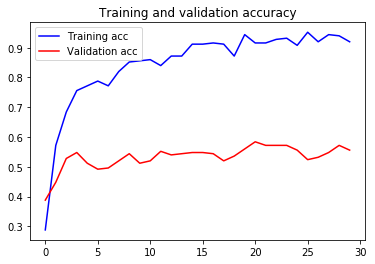

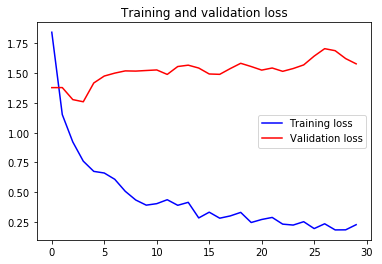

In [12]:
#plot training and validation accuracy, training and validation loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()